# Basic imports

In [1]:
from functools import partial
import pandas, csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc, hamming_loss, zero_one_loss, \
    jaccard_similarity_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.cross_validation import StratifiedKFold as SKF, cross_val_score, KFold
from scipy.special import expit
from sklearn.multiclass import OneVsRestClassifier

# Real data

Results in X, Y

In [2]:
dataPath = "../data/"

# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [3]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

Protein names equality check: True


In [4]:
print receptor_names

['NR-AhR' 'NR-AR-LBD' 'NR-AR' 'SR-MMP' 'NR-ER' 'SR-HSE' 'SR-p53'
 'NR-PPAR-gamma' 'SR-ARE' 'NR-Aromatase' 'SR-ATAD5' 'NR-ER-LBD']


# Model data

Results in Xm, Ym

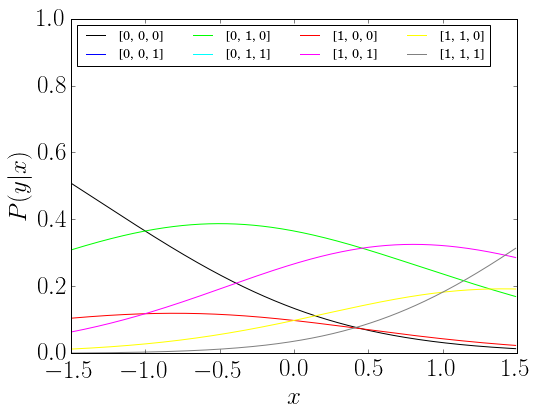

In [2]:
import ModelData
reload(ModelData)            

m = 500

# Model data
Xm, Ym = ModelData.get(m)

# Enable to show and save a chart
ModelData.plotDistribution()

# Number of classes
l = ModelData.l

## Base estimator

Will use it for both BR and PCC

In [3]:
estimator = LR(class_weight = 'balanced', fit_intercept = True, solver='liblinear', n_jobs=2)

## Cross validation strategy

In [4]:
cv = KFold(Xm.shape[0], n_folds = 5)

## Array of metrics

In [6]:
import MLCCV
reload(MLCCV)
import MLCLoss
reload(MLCLoss)

# Metrics for each column
column_metrics = {"H": MLCLoss.HammingLossN, "P": precision_score, "R": recall_score, "AUC": roc_auc_score}

# Metrics for whole matrices
metrics = {"S": MLCLoss.subsetLossN, "H": MLCLoss.HammingLossN}

# Make a matrix metric from column metric
for m in column_metrics:
    for i in range(1, l + 1):
        metrics[m + " " + str(i)] = partial(MLCCV.metric_ith_column, f = column_metrics[m], i = i - 1)

## Results

In [7]:
# result: classifiers x metrics x folds
result = {}

## Training BR

In [8]:
BR = OneVsRestClassifier(estimator, n_jobs = 3)

result["BR"] = MLCCV.cross_val_score_multiple_metrics(estimator = BR, metrics = metrics,
                                cv = cv, X = Xm, Y = Ym)

## Array of losses for PCC

In [9]:
losses = {"H": MLCLoss.HammingLoss, "S": MLCLoss.subsetLoss}
losses['M1'] = partial(MLCLoss.middleLoss, t = [0, 2, 5, 10])
losses['M2'] = partial(MLCLoss.middleLoss, t = [0, 2, 2, 10])
losses['M3'] = partial(MLCLoss.middleLoss, t = [0, 0, 2, 10])

# Array of middle losses
#x1 = 0
#step = 0.5
#while x1 <= 10:
#    x2 = x1
#    while x2 <= 10:
#        losses["M" + str((0, x1, x2, 10))] = partial(MLCLoss.middleLoss, t = [0, x1, x2, 10])
#        x2 += step
#    x1 += step

## Training PCC

In [10]:
import PCC
reload(PCC)
for loss in losses:
    print "PCC LOSS " + loss
    classifier = PCC.PCC(estimator = estimator, loss = losses[loss])
    
    result["PCC_" + loss] = MLCCV.cross_val_score_multiple_metrics(estimator = classifier, metrics = metrics,
                                cv = cv, X = Xm, Y = Ym)

PCC LOSS H
i=0 coef=[[ 0.95755582]]
i=1 coef=[[ 1.00421775 -1.70515025]]
i=2 coef=[[ 0.95716885  3.92735855 -1.82228142]]
i=0 coef=[[ 1.00385705]]
i=1 coef=[[ 1.13721927 -1.77573205]]
i=2 coef=[[ 1.02268347  3.84347676 -1.82419117]]
i=0 coef=[[ 0.9807998]]
i=1 coef=[[ 1.07846579 -1.69430062]]
i=2 coef=[[ 1.06639847  3.77894423 -1.82590549]]
i=0 coef=[[ 1.08521417]]
i=1 coef=[[ 0.96417212 -1.64942811]]
i=2 coef=[[ 1.12647809  3.82504967 -2.05797822]]
i=0 coef=[[ 1.05777553]]
i=1 coef=[[ 1.03025172 -1.67051632]]
i=2 coef=[[ 1.06941776  3.84383498 -1.96045164]]
PCC LOSS S
i=0 coef=[[ 0.95755582]]
i=1 coef=[[ 1.00421775 -1.70515025]]
i=2 coef=[[ 0.95716885  3.92735855 -1.82228142]]
i=0 coef=[[ 1.00385705]]
i=1 coef=[[ 1.13721927 -1.77573205]]
i=2 coef=[[ 1.02268347  3.84347676 -1.82419117]]
i=0 coef=[[ 0.9807998]]
i=1 coef=[[ 1.07846579 -1.69430062]]
i=2 coef=[[ 1.06639847  3.77894423 -1.82590549]]
i=0 coef=[[ 1.08521417]]
i=1 coef=[[ 0.96417212 -1.64942811]]
i=2 coef=[[ 1.12647809  3.8250

## Finding best loss function for a metric

In [11]:
ModelData.bestLoss(result, "S")
ModelData.bestLoss(result, "H")

PCC_S [0.66, 0.6, 0.6, 0.7, 0.61]
PCC_M3 [0.79, 0.77, 0.78, 0.79, 0.77]
PCC_H [0.29333333333333333, 0.31333333333333335, 0.3333333333333333, 0.36, 0.3466666666666667]
PCC_S [0.36333333333333334, 0.31, 0.35, 0.43666666666666665, 0.3566666666666667]


## Printing results

In [12]:
res_mean_std = {}
for a in result:
    res_mean_std[a] = {}
    for b in result[a]:
        m = np.mean(result[a][b])
        s = np.std(result[a][b])
        r = "%0.2g +- %0.1g" % (m, s)
        #print a,b,r
        res_mean_std[a][b] = r
df = pandas.DataFrame(res_mean_std)
#df.to_csv("ModelData_SearchingForLossFunction.csv", sep='\t', encoding='utf-8')
#df.to_csv("ModelData_Result.csv", sep='\t', encoding='utf-8')

In [13]:
df

,BR,PCC_H,PCC_M1,PCC_M2,PCC_M3,PCC_S
AUC 1,0.68 +- 0.05,0.68 +- 0.05,0.68 +- 0.04,0.68 +- 0.03,0.67 +- 0.04,0.68 +- 0.04
AUC 2,0.64 +- 0.05,0.63 +- 0.05,0.61 +- 0.05,0.62 +- 0.05,0.58 +- 0.07,0.54 +- 0.05
AUC 3,0.66 +- 0.05,0.67 +- 0.06,0.66 +- 0.05,0.65 +- 0.03,0.62 +- 0.02,0.67 +- 0.05
H,0.34 +- 0.02,0.33 +- 0.02,0.34 +- 0.02,0.34 +- 0.01,0.36 +- 0.01,0.36 +- 0.04
H 1,0.32 +- 0.05,0.32 +- 0.05,0.33 +- 0.03,0.33 +- 0.03,0.35 +- 0.04,0.32 +- 0.04
H 2,0.37 +- 0.04,0.38 +- 0.04,0.39 +- 0.04,0.39 +- 0.04,0.43 +- 0.04,0.46 +- 0.05
H 3,0.32 +- 0.05,0.29 +- 0.05,0.29 +- 0.05,0.29 +- 0.03,0.31 +- 0.03,0.3 +- 0.05
P 1,0.68 +- 0.1,0.68 +- 0.1,0.73 +- 0.06,0.78 +- 0.04,0.82 +- 0.05,0.59 +- 0.07
P 2,0.63 +- 0.06,0.61 +- 0.06,0.56 +- 0.05,0.56 +- 0.05,0.45 +- 0.07,0.53 +- 0.04
P 3,0.7 +- 0.1,0.58 +- 0.1,0.54 +- 0.09,0.44 +- 0.07,0.31 +- 0.07,0.68 +- 0.1


In [548]:
print df.to_latex()

\begin{tabular}{lllll}
\toprule
{} &             BR &         PCC\_H &         PCC\_M &         PCC\_S \\
\midrule
AUC 1 &   0.69 +- 0.03 &  0.69 +- 0.03 &  0.69 +- 0.02 &  0.69 +- 0.05 \\
AUC 2 &   0.55 +- 0.04 &  0.55 +- 0.04 &  0.56 +- 0.03 &  0.51 +- 0.04 \\
AUC 3 &   0.65 +- 0.04 &  0.66 +- 0.02 &  0.64 +- 0.04 &  0.64 +- 0.04 \\
H     &  0.37 +- 0.009 &  0.36 +- 0.02 &  0.36 +- 0.02 &  0.38 +- 0.04 \\
H 1   &   0.31 +- 0.03 &  0.31 +- 0.03 &  0.31 +- 0.02 &  0.31 +- 0.05 \\
H 2   &   0.45 +- 0.04 &  0.45 +- 0.04 &  0.45 +- 0.03 &  0.49 +- 0.05 \\
H 3   &   0.34 +- 0.03 &   0.3 +- 0.03 &  0.31 +- 0.04 &  0.34 +- 0.03 \\
P 1   &    0.7 +- 0.06 &   0.7 +- 0.06 &  0.73 +- 0.05 &  0.64 +- 0.05 \\
P 2   &   0.55 +- 0.04 &  0.51 +- 0.01 &  0.47 +- 0.04 &  0.46 +- 0.07 \\
P 3   &    0.7 +- 0.06 &  0.56 +- 0.05 &    0.5 +- 0.1 &  0.66 +- 0.05 \\
R 1   &   0.68 +- 0.04 &  0.68 +- 0.04 &  0.68 +- 0.03 &  0.71 +- 0.05 \\
R 2   &    0.52 +- 0.1 &   0.53 +- 0.1 &  0.54 +- 0.09 &  0.48 +- 0.05 